# Visualization of different values of discriminative need

(For one meaning distribution)

## Configs

In [22]:
import os
import torch
import pandas as pd
import plotnine as pn

In [23]:
# Constants 

# example fn
"multirun/states=10/words=10/prior=-8/dist=squared_dist/meaning_certainty=-2/discr_need=-1/seed=42/dynamics=two_population_rd/num_trials=10/population_size=None/simulation_points.csv"

# seems like it should be


# standard configs
num_states = 100
num_signals = 100
prior = -8
distance = "squared_dist"
meaning_certainty = 0
seed = 42

discr_needs = torch.arange(-3, 4, 0.5).tolist() # swept values
# discr_needs = torch.arange(-3, -1, 0.5).tolist() # for 1000

# Replicator Dynamics specific configs
dynamics = "two_population_rd"
num_trials = 8
population_size = None

# # Nowak Krakauer specific configs
# dynamics = "nowak_krakauer"
# num_trials = 8
# population_size = 100

# # Moran process specific configs
# dynamics = "moran_process"
# num_trials = 8
# population_size = 100

## Load Data

In [24]:
# Filepaths

# user's path to root of repo
root_path = "/Users/nathanielimel/uci/projects/ibsg"

#############################################################################
# Analysis files
#############################################################################

curve_fn = f"multirun/states={num_states}/signals={num_signals}/prior={prior}/dist={distance}/meaning_certainty={meaning_certainty}/curve_points.csv"

ub_curve_fn = curve_fn.replace("curve_points", "ub_curve_points")

#############################################################################
# Simulation points
#############################################################################

sim_fns = {
    f"{discr_need}":
    f"multirun/states={num_states}/signals={num_signals}/prior={prior}/dist={distance}/meaning_certainty={meaning_certainty}/discr_need={discr_need}/seed={seed}/dynamics={dynamics}/num_trials={num_trials}/population_size={population_size}/simulation_points.csv"
    for discr_need in discr_needs
    }


In [25]:
# load dataframes
read = lambda fn: pd.read_csv(os.path.join(root_path, fn))
get_dfs_dict = lambda fns: {k: read(fns[k]) for k in fns}

curve_data = read(curve_fn)
ub_curve_data = read(ub_curve_fn)

sim_dfs = get_dfs_dict(sim_fns)

# sim_dfs = {k: read(sim_fns[k]) for k in sim_fns}
# ub_sim_dfs = {k: read(ub_sim_fns[k]) for k in ub_sim_fns}

# curve_data = pd.read_csv(curve_fn)
# sim_dfs = {k: pd.read_csv(sim_fns[k]) for k in sim_fns}

## Configure aesthetics

In [26]:
# label each df to be concatenated with a columns
for key in sim_dfs:
    df = sim_dfs[key]
    df["discr_need"] = key


sim_data = pd.concat(sim_dfs.values())

In [27]:
sim_data["discr_need"] = sim_data["discr_need"].astype(float)
sim_data # N.B.: nans are expected for 'round' column

,complexity,accuracy,distortion,mse,discr_need
0,4.786543,4.072900,1.038771,4.858371,-3.0
1,4.188958,3.806145,1.305526,6.462536,-3.0
2,-0.000006,-0.000002,5.111672,1666.501800,-3.0
3,4.153999,3.768877,1.342793,6.828117,-3.0
4,4.827478,4.072753,1.038917,5.558525,-3.0
...,...,...,...,...,...
3,6.443856,4.911683,0.199987,86.359990,3.5
4,6.403856,4.885859,0.225813,154.589980,3.5
5,6.308759,4.790750,0.320921,263.993320,3.5
6,6.356308,4.830010,0.281661,233.849990,3.5


## Plot

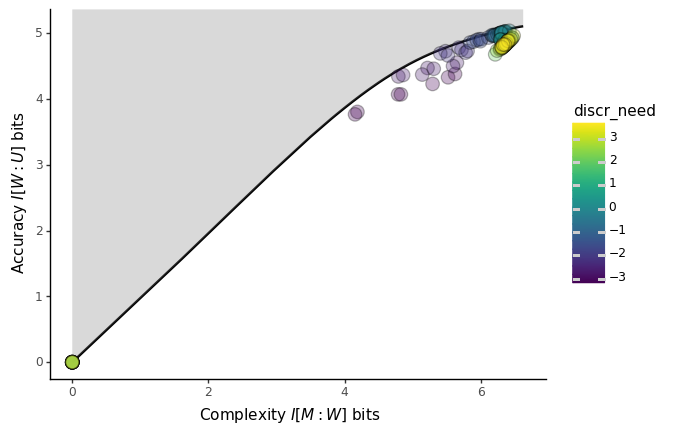

In [28]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=curve_data, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=1) # IB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_jitter( # emergent langs
        data=sim_data,
        mapping=pn.aes(
            fill="discr_need",
            # shape="language",
            ),
        alpha=0.3,
        size=5,
    )        
    + pn.xlab("Complexity $I[M:W]$ bits")
    + pn.ylab("Accuracy $I[W:U]$ bits")
    + pn.theme_classic()
)
print(plot)

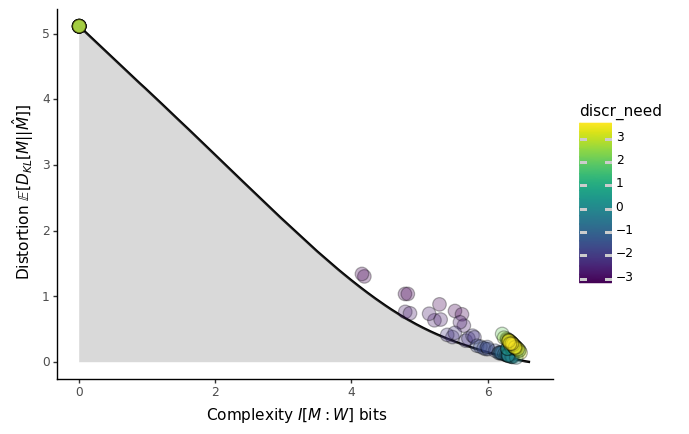

In [29]:
cc_plot = (
    # Set data and the axes
    pn.ggplot(
        data=curve_data, mapping=pn.aes(x="complexity", y="distortion")
    )  
    + pn.geom_line(size=1) # IB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin=0,
        ymax="distortion",
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_jitter( # emergent langs
        data=sim_data,
        mapping=pn.aes(
            fill="discr_need",
            # shape="language",
            ),
        alpha=0.3,
        size=5,
    )        
    + pn.xlab("Complexity $I[M:W]$ bits")
    + pn.ylab("Distortion $\mathbb{E}[D_{KL}[ M || \hat{M} ]]$")
    + pn.theme_classic()
)
print(cc_plot)

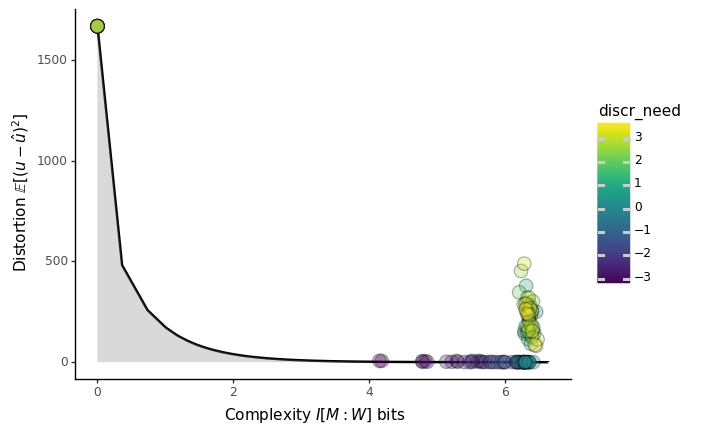

In [30]:
ub_plot = (
    # Set data and the axes
    pn.ggplot(
        data=ub_curve_data, mapping=pn.aes(x="complexity", y="mse")
    )  
    + pn.geom_line(size=1) # UB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin=0,
        ymax="mse",
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_jitter( # emergent langs
        data=sim_data,
        mapping=pn.aes(
            fill="discr_need",
            # shape="language",
            ),
        alpha=0.3,
        size=5,
    )        
    + pn.xlab("Complexity $I[M:W]$ bits")
    + pn.ylab("Distortion $\mathbb{E}[(u - \hat{u})^2]$")
    + pn.theme_classic()
)
print(ub_plot)

## Save plots

In [31]:
# save plots in folder where curve is found
plot_dir = os.path.join(root_path, curve_fn).replace("curve_points.csv", "")
plots = {
    "complexity_accuracy": plot,
    "complexity_distortion": cc_plot,
    "complexity_mse": ub_plot,
}


for fn in plots:
    plots[fn].save(os.path.join(plot_dir, fn), width=10, height=10, dpi=300,)

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/nathanielimel/uci/projects/ibsg/multirun/states=100/signals=100/prior=-8/dist=squared_dist/meaning_certainty=0/complexity_accuracy
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/nathanielimel/uci/projects/ibsg/multirun/states=100/signals=100/prior=-8/dist=squared_dist/meaning_certainty=0/complexity_distortion
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packa